# fast neural style  基于VGG16的快速图像风格化

In [31]:
import argparse
import os
import sys
import time
import re

import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import torch.onnx

import utils
from transformer_net import TransformerNet
from vgg import Vgg16

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import onnxruntime

from argparse import Namespace

## 引入matplotlib库，实现可视化输出

In [32]:
def show_images_side_by_side(original_image_path, stylized_image_path,style_image_path, title1='Original Image', title2='Stylized Image', title3='the Style Image'):
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))  # 创建一个包含两个子图的图形
    
    # 加载并显示原始图像
    original_img = mpimg.imread(original_image_path)
    axs[0].imshow(original_img)
    axs[0].set_title(title1)
    axs[0].axis('off')  # 不显示坐标轴

    # 加载并显示风格化后的图像
    stylized_img = mpimg.imread(stylized_image_path)
    axs[1].imshow(stylized_img)
    axs[1].set_title(title2)
    axs[1].axis('off')  # 不显示坐标轴

    style_img = mpimg.imread(style_image_path)
    axs[2].imshow(style_img)
    axs[2].set_title(title3)
    axs[2].axis('off')  # 不显示坐标轴
    
    plt.show()

## ONNX风格化函数
使用ONNX运行时进行风格化处理。

In [33]:
def stylize_onnx(content_image, args):
    """
    Read ONNX model and run it using onnxruntime
    """

    assert not args.export_onnx


    ort_session = onnxruntime.InferenceSession(args.model)

    def to_numpy(tensor):
        return (
            tensor.detach().cpu().numpy()
            if tensor.requires_grad
            else tensor.cpu().numpy()
        )

    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(content_image)}
    ort_outs = ort_session.run(None, ort_inputs)
    img_out_y = ort_outs[0]

    return torch.from_numpy(img_out_y)


## 风格化函数
该部分封装了风格化函数

In [34]:
def stylize(args):
    # device = torch.device("cuda" if args.cuda else "cpu")
    device = torch.device("cuda:1")

    content_image = utils.load_image(args.content_image, scale=args.content_scale)
    content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = content_transform(content_image)
    content_image = content_image.unsqueeze(0).to(device)

    style_image = utils.load_image(args.style_image, scale=args.style_scale) if args.style_image else None

    if args.model.endswith(".onnx"):
        output = stylize_onnx(content_image, args)
    else:
        with torch.no_grad():
            style_model = TransformerNet()
            state_dict = torch.load(args.model)
            for k in list(state_dict.keys()):
                if re.search(r'in\d+\.running_(mean|var)$', k):
                    del state_dict[k]
            style_model.load_state_dict(state_dict)
            style_model.to(device)
            style_model.eval()
            if args.export_onnx:
                assert args.export_onnx.endswith(".onnx"), "Export model file should end with .onnx"
                output = torch.onnx._export(style_model, content_image, args.export_onnx, opset_version=11).cpu()            
            else:
                output = style_model(content_image).cpu()

    # 保存并显示图像
    utils.save_image(args.output_image, output[0])
    show_images_side_by_side(args.content_image, args.output_image, args.style_image)




## 图像风格化封装函数

In [35]:
def stylize_image(content_image, style_image, model, output_image, cuda, content_scale=None, style_scale=None, export_onnx=None):
    args = argparse.Namespace(
        content_image=content_image,
        style_image=style_image,
        model=model,
        output_image=output_image,
        cuda=cuda,
        content_scale=content_scale,
        style_scale=style_scale,
        export_onnx=export_onnx
    )

    # 调用原先的 stylize 函数
    stylize(args)



## 主函数调用

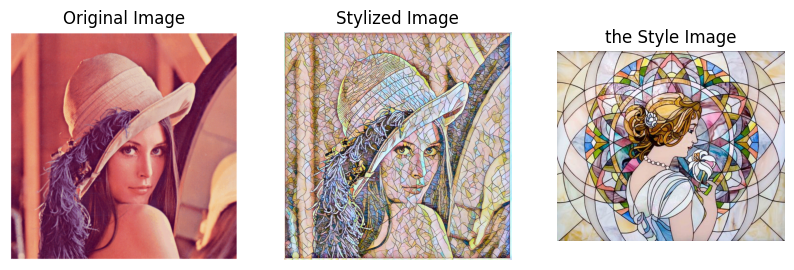

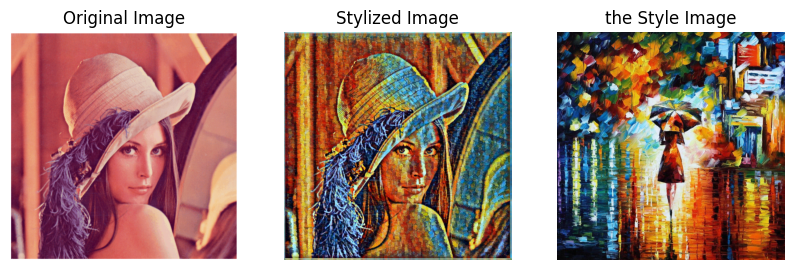

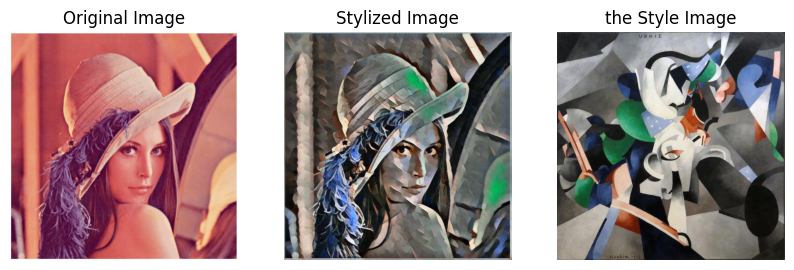

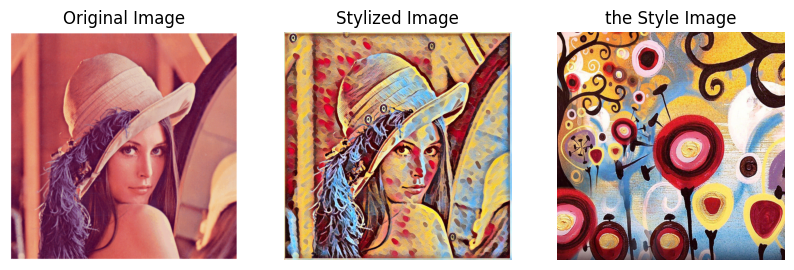

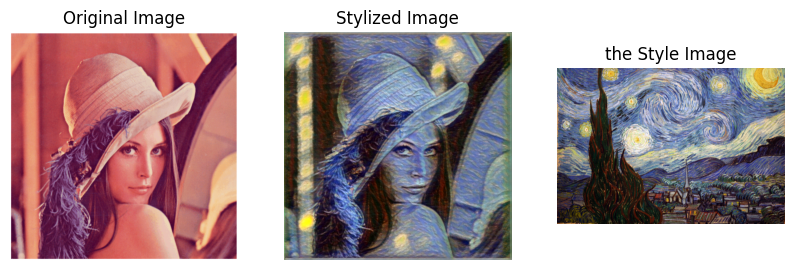

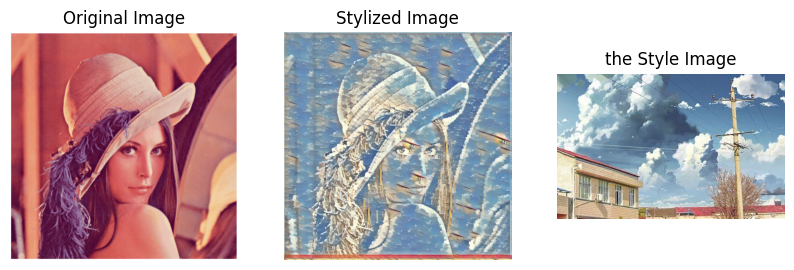

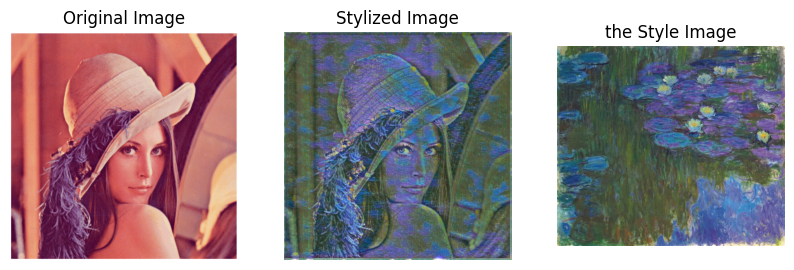

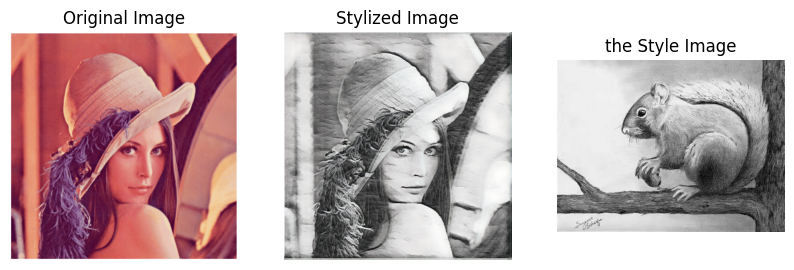

In [36]:
if __name__ == "__main__":
    
    ### 调用 stylize_image 函数
    # 使用具体的参数调用函数
    stylize_image(
        content_image="../images/content_images/lenna.png",
        style_image="../images/style_images/mosaic.jpg",
        model="../new_saved_model/mosaic.pth",
        output_image="../images/output_images/mosaic-final.jpg",
        cuda=1
    )  
    stylize_image(
        content_image="../images/content_images/lenna.png",
        style_image="../images/style_images/rain-princess.jpg",
        model="../new_saved_model/rain_princess.pth",
        output_image="../images/output_images/rain_princess-final.jpg",
        cuda=1
    )  
    stylize_image(
        content_image="../images/content_images/lenna.png",
        style_image="../images/style_images/udnie.jpg",
        model="../new_saved_model/udnie.pth",
        output_image="../images/output_images/udnie-final.jpg",
        cuda=1
    ) 
    stylize_image(
        content_image="../images/content_images/lenna.png",
        style_image="../images/style_images/candy.jpg",
        model="../new_saved_model/candy.pth",
        output_image="../images/output_images/candy-final.jpg",
        cuda=1
    )  
   

    stylize_image(
        content_image="../images/content_images/lenna.png",
        style_image="../images/style_images/vanGogh.jpg",
        model="../new_saved_model/vangogh-final.model",
        output_image="../images/output_images/vangogh-lenna.png",
        cuda=1
    )

    stylize_image(
        content_image="../images/content_images/lenna.png",
        style_image="../images/style_images/cartoon.png",
        model="../new_saved_model/cartoon-final.model",
        output_image="../images/output_images/cartoon-final.jpg",
        cuda=1
    )
    stylize_image(
        content_image="../images/content_images/lenna.png",
        style_image="../images/style_images/Monet.png",
        model="../new_saved_model/monet-final.model",
        output_image="../images/output_images/monet-final.jpg",
        cuda=1
    )
    stylize_image(
        content_image="../images/content_images/lenna.png",
        style_image="../images/style_images/sketch.jpg",
        model="../new_saved_model/sketch-final.model",
        output_image="../images/output_images/sketch-final.jpg",
        cuda=1
    )    
